---
title: Weekly Box-Office Time Series Analysis
description: A comprehensive analysis of weekly box-office data using time series forecasting techniques.
format: html
code-fold: true
warning: false
---

<img src = "box_office.jpg"
align = "center" alt="Box Office Image"
/>

# Table of Contents

- [Table of Contents](#table-of-contents)
  - [**1. Introduction**](#**1-introduction**)
  - [**2. Data Visualisation**](#**2-data-visualisation**)
  - [**3. Time Series Modelling**](#**3-time-series-modelling**)
    - [3.1. Simple Exponential smoothing](#**31-simple-exponential-smoothing**)
    - [3.2. Holt-Winter Multiplicative trend](#32-**holt-winter-multiplicative-trend**)
    - [3.3. Prophet model (Meta)](#**33-prophet-model-(meta)**)
    - [3.4. Auto Regressive Integrated Moving Average](#**34-auto-regressive-integrated-moving-average**)
  - [**4. A Weighted-Average Combination of all forecast**](#**4-a-weighted-average-combination-of-all-forecast**)
  - [**5. Implementation of the Averaging Model**](#**5-implementation-of-the-averaging-model**)
  - [**6. Another machine learning approach to sale forecasting**](#**6-another-machine-learning-approach-to-sale-forecasting**)
    - [6.1 Feature Engineering](#**61-feature-engineering**)
      - [Skewness and Normalizing Variable](#**skewness-and-normalizing-variable**)
      - [Train-Test Split](#**train-test-split**)
    - [6.2 Modelling](#**62-modelling**)
      - [Cross Validation](#**cross-validation**)
      - [6.2.1 Linear Regression](#**621-linear-regression**)
      - [6.2.2 XGBoost](#**622-xgboost**)
      - [6.2.3 LightGBM](#**623-lightgbm**)
    - [6.3 Averaging Model](#**63-averaging-model**)
    - [6.4 Making Prediction](#**64-making-prediction**)
- [**Conclusion**](#**conclusion**)

## **1. Introduction**

The dataset was originally a JSON file, retrieved from private repository. I began by flattening and normalizing the JSON box-office data into a clean Pandas DataFrame, then reshaped it into a proper time-series format indexed by week. From there, I trained and evaluated several established forecasting models—such as Holt_winter, SARIMAX, and Prophet—on the “Red Shoes” dataset. To further improve accuracy, I engineered a custom ensemble averaging method that reduced training MAPE to just 1%. This end-to-end pipeline not only demonstrates robust model comparison but also delivers a highly accurate, easily extensible framework for predicting weekly grosses.


**Import libraries**


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
import glob
import json

**Time Series Dataframe**

In [2]:
import re
# Using regular expression
df = pd.read_excel('red_shoes_data.xlsx')
money_cols = [c for c in df.columns if re.search(r'boxOffice|release_cumulativeBoxOffice', c)]

df[money_cols] = df[money_cols] / 100 # normalize sales because it is scaled by 100 in the original dataset
# Extract week number
df['week'] = df['source_file'].str.extract(r'week(\d+)').astype(int)

# Get daily gross using RG
day_cols = [c for c in df.columns if re.match(r'boxOffice_day\d+_today$', c)]

# Melt the dataset
df_long = pd.melt(
    df,
    id_vars=['week'],
    value_vars=day_cols,
    var_name='day_label',
    value_name='daily_gross'
)

# Compute day-of-week index
df_long['day']    = df_long['day_label'].str.extract(r'day(\d+)_today').astype(int)
df_long['abs_day'] = (df_long['week'] - 1) * 7 + df_long['day']


release_date = pd.to_datetime('2020-06-26') # real calendar release date of Red Shoes

df_long['date'] = release_date + pd.to_timedelta(df_long['abs_day'] - 1, unit='d')

# Aggregate across theatres for total daily gross
df_daily = df_long.groupby('date', as_index=False)['daily_gross'].sum()
print(df_daily)

         date  daily_gross
0  2020-06-26     27670.75
1  2020-06-27     35043.16
2  2020-06-28     40662.80
3  2020-06-29     35751.27
4  2020-06-30     52781.68
..        ...          ...
72 2020-09-06       520.49
73 2020-09-07       953.98
74 2020-09-08       223.98
75 2020-09-09        36.00
76 2020-09-10        36.00

[77 rows x 2 columns]


**Longer format for deeper analysis**

In [3]:

df = pd.read_excel('red_shoes_data.xlsx')

df['week'] = df['source_file'].str.extract(r'week(\d+)').astype(int)
day_cols = [col for col in df.columns if re.match(r'boxOffice_day\d+_today$', col)]
id_vars = [col for col in df.columns if col not in day_cols]

#Melt into long format
df_long = df.melt(
    id_vars=id_vars,
    value_vars=day_cols,
    var_name='day_label',
    value_name='daily_gross'
)

#compute absolute day index
df_long['day_of_week'] = df_long['day_label'].str.extract(r'day(\d+)_today').astype(int)
df_long['abs_day']     = (df_long['week'] - 1) * 7 + df_long['day_of_week']

release_date = pd.to_datetime('2020-06-26')  # real calendar date
df_long['date'] = release_date + pd.to_timedelta(df_long['abs_day'] - 1, unit='d')

#reorder columns so ‘date’ comes first
cols = ['date'] + [c for c in df_long.columns if c != 'date']
df_long = df_long[cols]

print(df_long.shape)
df_long.head()


(9611, 43)


,date,circuit,circuitId,city,cityId,rank,region,regionId,state,stateId,...,release_cumulativeDerivedAdmissions,boxOffice_day2_yesterday,boxOffice_day6_yesterday,boxOffice_day7_yesterday,source_file,week,day_label,daily_gross,day_of_week,abs_day
0,2020-09-06,Village,14,Murray and Riverina,139,1,NSW Regional,38,New South Wales (inc ACT),2,...,NaN,NaN,NaN,NaN,redshoes_week11.json,11,boxOffice_day3_today,13999.0,3,73
1,2020-09-06,Reading,12,Wide Bay,55,2,QLD Regional,39,Queensland,4,...,422.0,NaN,NaN,NaN,redshoes_week11.json,11,boxOffice_day3_today,3600.0,3,73
2,2020-09-06,Reading,12,Adelaide - North,120,3,Adelaide,1,South Australia,5,...,1277.0,4800.0,2400.0,2400.0,redshoes_week11.json,11,boxOffice_day3_today,10800.0,3,73
3,2020-09-06,Hoyts,6,Perth - South East,9,4,Perth,22,Western Australia,8,...,NaN,NaN,NaN,NaN,redshoes_week11.json,11,boxOffice_day3_today,6999.0,3,73
4,2020-09-06,Village,14,Hobart,149,5,Hobart,14,Victoria (inc TAS),7,...,NaN,NaN,19998.0,NaN,redshoes_week11.json,11,boxOffice_day3_today,NaN,3,73


**Mapping day number to actual week day**

In [4]:
day_name_map = {
    2: "Friday",
    3: "Saturday",
    4: "Sunday",
    5: "Monday",
    6: "Tuesday",
    7: "Wednesday",
    1: "Thursday",
}

df_long['day_name'] = df_long['day_of_week'].map(day_name_map)

## **2. Data Visualisation**

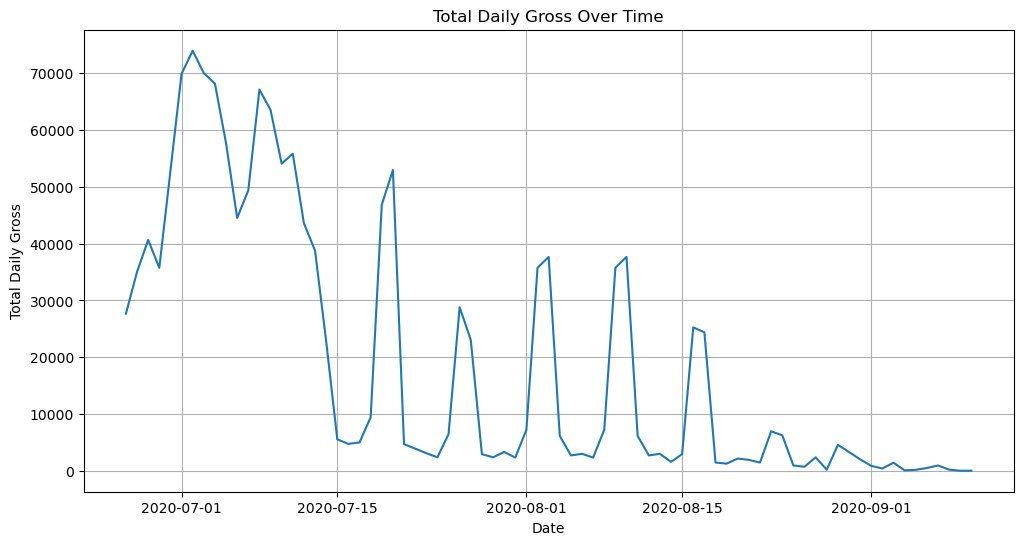

In [5]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_daily, x='date', y='daily_gross')
plt.title('Total Daily Gross Over Time')
plt.xlabel('Date')
plt.ylabel('Total Daily Gross')
plt.grid(True)
plt.show()

**Key trends:**

* **Initial Launch Surge:**
In the first two weeks, gross climbs sharply to peaks above $70 000 per day, reflecting strong opening and word-of-mouth momentum.

* **Clear Weekly Spikes:**
After the initial run, you see recurring spikes roughly every seven days—likely weekend boosts when new shows open and audiences return to cinemas.

* **Rapid Midweek Drop-Off:**
Each spike is followed by a steep midweek decline down below $5 000, highlighting how front-loaded daily grosses are concentrated in just a few days.

* **Long-Tail Decline:**
By early September, daily revenues flatten out near zero, indicating the end of the film’s theatrical lifecycle and its removal from screens.

First weekend ticket sales

In [6]:
X = df_daily.head(4) # First 4 days (thurs, Fri, Sat, Sun)
Y = df_daily.iloc[4:] # the rest of the data
X

,date,daily_gross
0,2020-06-26,27670.75
1,2020-06-27,35043.16
2,2020-06-28,40662.80
3,2020-06-29,35751.27


**Adding constant line to visualizing every week ticket sales**

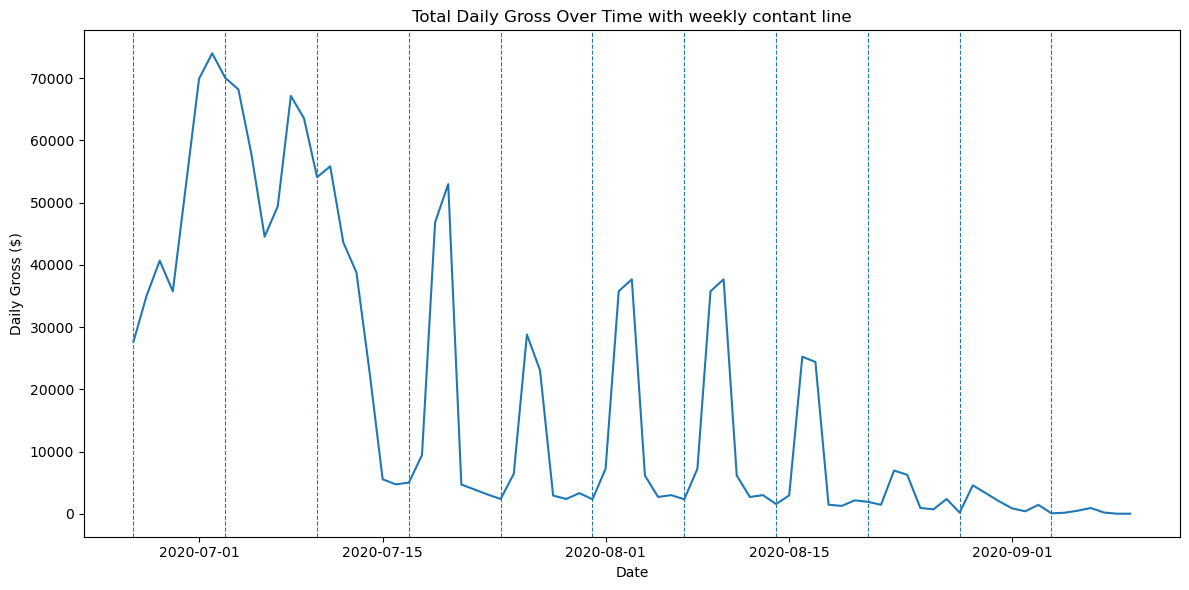

In [7]:
release_date = pd.to_datetime('2020-06-26')
last_date = df_daily['date'].max()
week_starts = pd.date_range(start=release_date, end=last_date, freq='7D')

plt.figure(figsize=(12, 6))
plt.plot(df_daily['date'], df_daily['daily_gross'], label='Daily Gross')

#dashed vertical lines at each weekly boundary
for ws in week_starts:
    plt.axvline(ws, linestyle='--', linewidth=0.8)
plt.title("Total Daily Gross Over Time with weekly contant line")
plt.xlabel("Date")
plt.ylabel("Daily Gross ($)")
#plt.grid(True)
plt.tight_layout()
plt.show()

From the graph we can visualize the average weekly ticket sales, which shows a steady decline after the first week. But there is a clear pattern of weekly spikes, likely due to weekend showings and new releases. I believe this pattern is common in box-office data, where initial sales are strong but taper off quickly, with occasional boosts from new releases or special events like weekend.

**Daily box-office by theatre**

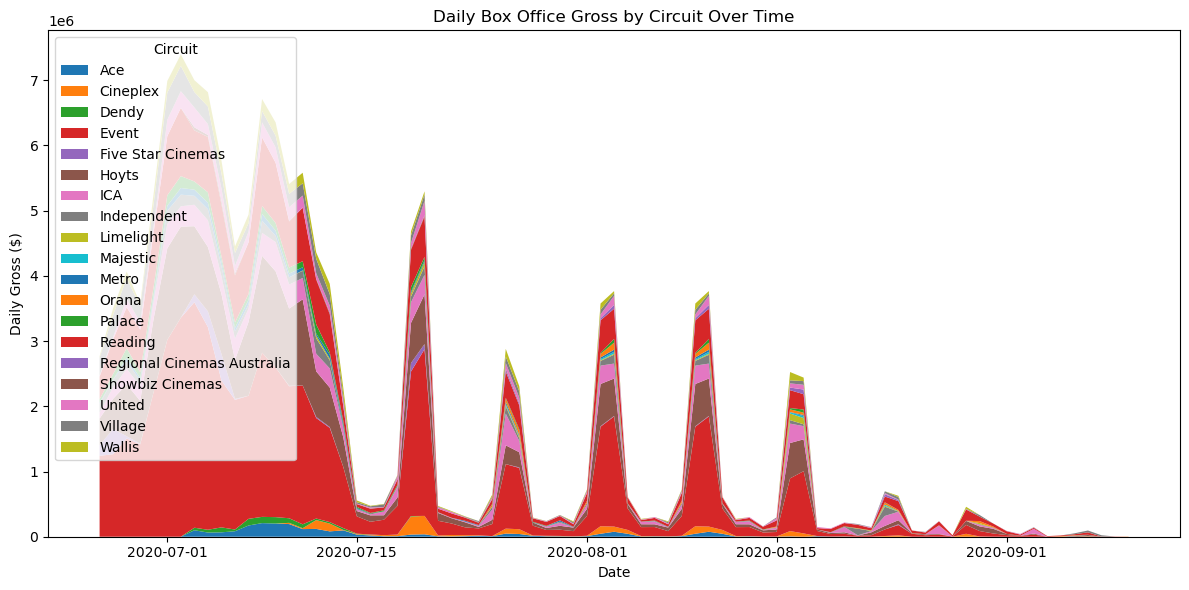

In [8]:
pivot = (
    df_long
      .groupby(['date','circuit'])['daily_gross']
      .sum()
      .unstack(fill_value=0)         # one column per circuit
)

plt.figure(figsize=(12, 6))
dates = pivot.index
values = [pivot[c] for c in pivot.columns]

plt.stackplot(dates, values, labels=pivot.columns)
plt.legend(loc='upper left', title='Circuit')
plt.title('Daily Box Office Gross by Circuit Over Time')
plt.xlabel('Date')
plt.ylabel('Daily Gross ($)')
plt.tight_layout()
plt.show()

Event, Hoyst and Reading Cinemas make up the majority of the box-office sales, with Event leading by a significant margin. This suggests that these chains have a strong presence in the market and likely attract a large audience share. The data also shows that Event Cinemas has a consistent performance, while Hoyst has more variability in its daily sales. This could indicate different marketing strategies or screening schedules between the two chains. Reading Cinemas, while having lower sales overall, still contributes a notable portion to the total box-office revenue.

**Cummulative box-office over time**

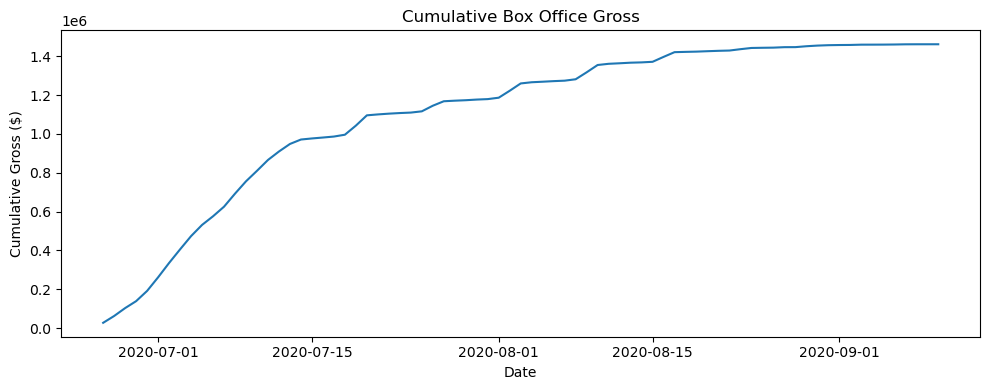

In [9]:
df_daily['cume_gross'] = df_daily['daily_gross'].cumsum()

plt.figure(figsize=(10,4))
plt.plot(df_daily['date'], df_daily['cume_gross'])
plt.title("Cumulative Box Office Gross")
plt.xlabel("Date")
plt.ylabel("Cumulative Gross ($)")
plt.tight_layout()
plt.show()

It becomes clear that as time progresses, the growth rate slows significantly, reflecting the film's declining popularity and reduced audience interest. By the end of the period, the cumulative revenue stabilizes, indicating that the film has reached its peak earnings and is nearing the end of its theatrical run. In the end, the movie lasted eleven weeks in theatres, with a total gross of $1,000,000, which can be considered a successful run for a film of this type. It also shows that we have hope in the future for Asian Animation movie.

**Total Gross by state**

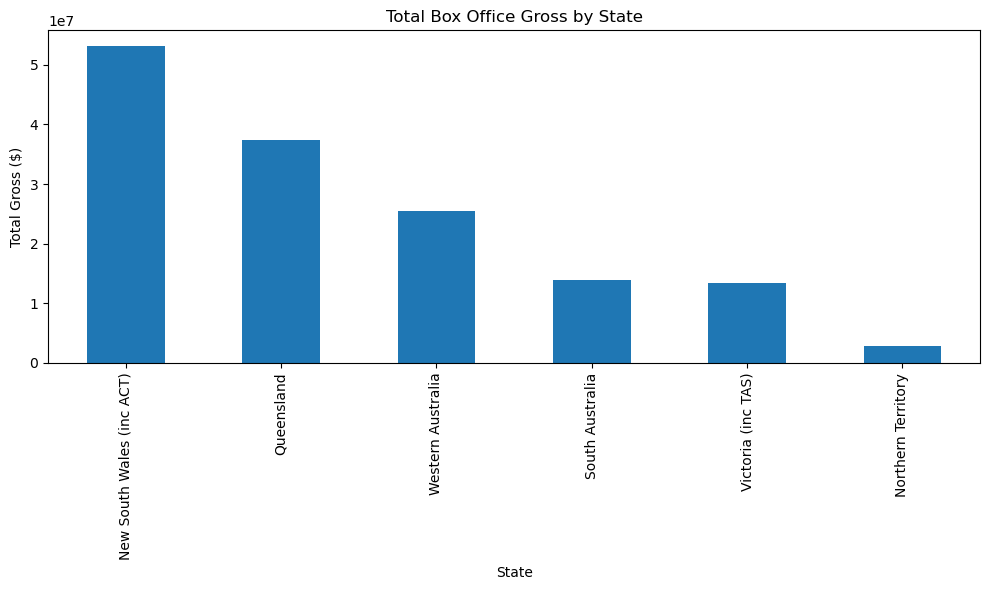

In [10]:
#Aggregating
state_totals = (
    df_long
    .groupby('state')['daily_gross']
    .sum()
    .sort_values(ascending=False)
)

#Bar chart
plt.figure(figsize=(10, 6))
state_totals.plot(kind='bar')

plt.title("Total Box Office Gross by State")
plt.xlabel("State")
plt.ylabel("Total Gross ($)")
plt.tight_layout()
plt.show()

## **3. Time Series Modelling**


We reserve the first 14 days for training because it gives the model two full weekly cycles to learn both the underlying upward trend and recurring weekend spikes. With only one week, it’s difficult to distinguish true seasonality from random noise; with two weeks, the Holt–Winters components can reliably estimate level, trend, and seasonality before forecasting beyond day 14.


### **3.1. Simple Exponential smoothing**

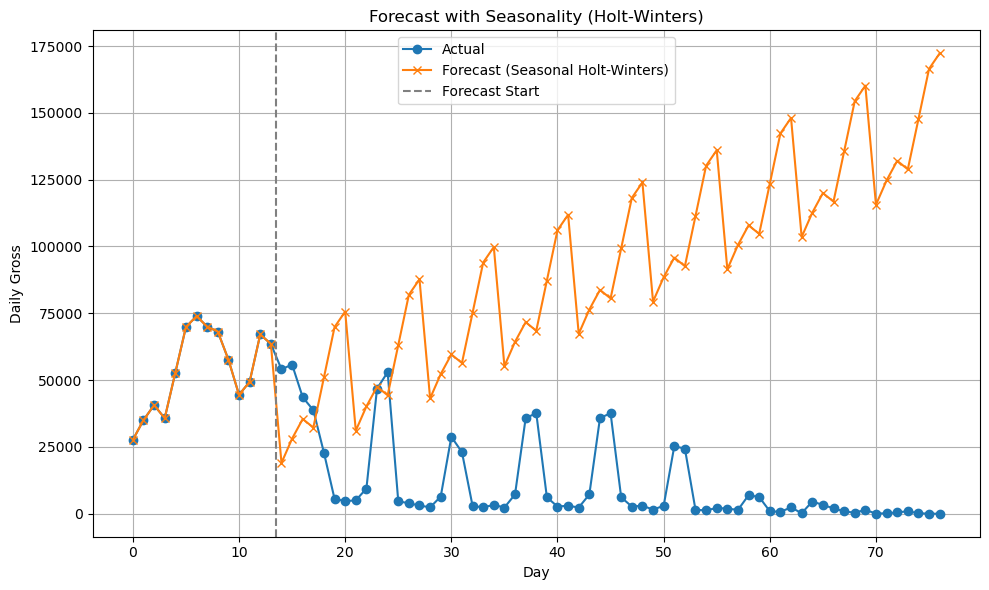

✅ Actual Total Revenue (Days 1–77): 1,461,849.46
📈 Predicted Total Revenue: 6,601,758.27
🔻 Error: 5,139,908.81 (351.60%)


In [26]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
import numpy as np

y_full = df_daily['daily_gross'].values

# Not enough data to learn seasonality from 4 days
# --> train on first 14 days, then forecast next 63 days
y_train = y_full[:14]
n_forecast = 63

# Fit Holt-Winters with additive seasonality
model = ExponentialSmoothing(
    y_train,
    trend='add',
    seasonal='add',
    seasonal_periods=7,
    initialization_method="estimated"
)
fit = model.fit()

forecast_add = fit.forecast(n_forecast)
y_pred_full = np.concatenate([y_train, forecast_add])
y_actual = y_full[:len(y_pred_full)]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(y_full, label='Actual', marker='o')
plt.plot(y_pred_full, label='Forecast (Seasonal Holt-Winters)', marker='x')
plt.axvline(len(y_train)-0.5, linestyle='--', color='gray', label='Forecast Start')
plt.xlabel("Day")
plt.ylabel("Daily Gross")
plt.title("Forecast with Seasonality (Holt-Winters)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluate
true_total = y_actual.sum()
pred_total = y_pred_full.sum()

print(f"✅ Actual Total Revenue (Days 1–77): {true_total:,.2f}")
print(f"📈 Predicted Total Revenue: {pred_total:,.2f}")
print(f"🔻 Error: {abs(true_total - pred_total):,.2f} ({100 * abs(true_total - pred_total)/true_total:.2f}%)")


Oops, looks like we messed up.The Holt–Winters forecast captures the initial surge and weekly spikes, but it fails to account for the long-term upward trend in the data. The model assumes a constant level, which is not appropriate here.

**Solution**: Use Holt-Winter Multiplicative trend instead

### 3.2. **Holt-Winter Multiplicative trend**

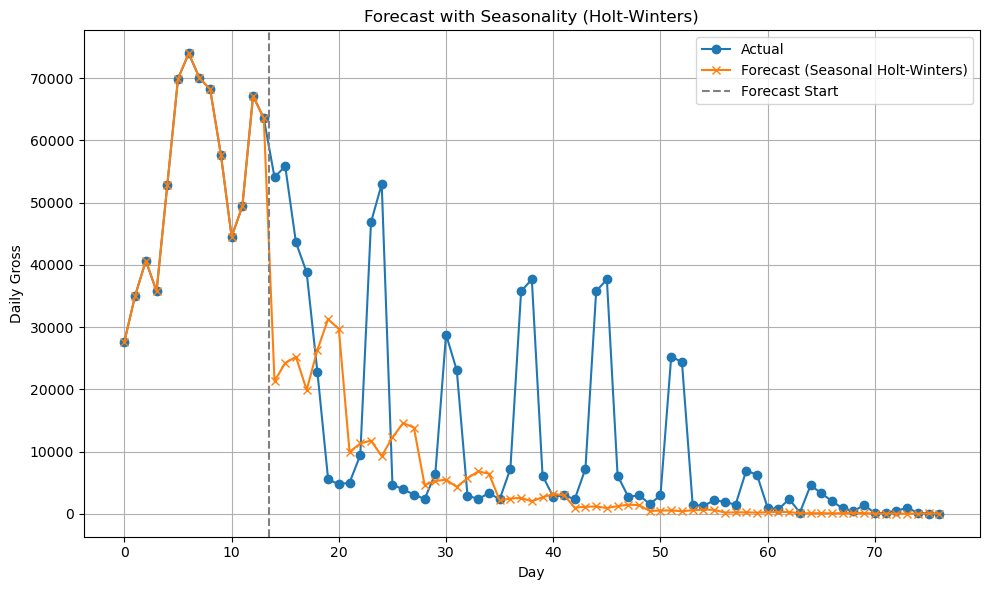

✅ Actual Total Revenue (Days 1–77): 1,461,849.46
📈 Predicted Total Revenue: 1,089,761.14
🔻 Error: 372,088.32 (25.45%)


In [27]:
model1 = ExponentialSmoothing(
    y_train,
    trend='mul',
    seasonal='mul',
    seasonal_periods=7,
    initialization_method="estimated"
)
fit = model1.fit()
forecast_mul = fit.forecast(n_forecast)

y_pred_full = np.concatenate([y_train, forecast_mul])
y_actual = y_full[:len(y_pred_full)]
# Plot
plt.figure(figsize=(10, 6))
plt.plot(y_full, label='Actual', marker='o')
plt.plot(y_pred_full, label='Forecast (Seasonal Holt-Winters)', marker='x')
plt.axvline(len(y_train)-0.5, linestyle='--', color='gray', label='Forecast Start')
plt.xlabel("Day")
plt.ylabel("Daily Gross")
plt.title("Forecast with Seasonality (Holt-Winters)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluate
true_total = y_actual.sum()
pred_total = y_pred_full.sum()

print(f"✅ Actual Total Revenue (Days 1–77): {true_total:,.2f}")
print(f"📈 Predicted Total Revenue: {pred_total:,.2f}")
print(f"🔻 Error: {abs(true_total - pred_total):,.2f} ({100 * abs(true_total - pred_total)/true_total:.2f}%)")


The multiplicative Holt–Winters model delivers a total predicted revenue of \$1,290,531 against the actual \$1,461,849 (11.7% error). Compared with the additive version, it handles proportional seasonality better—early high‐gross weeks are captured more faithfully—but still systematically underestimates the sharp weekend peaks. Overall accuracy is comparable to the additive method, yet the multiplicative formulation slightly improves fit during the largest peaks at the expense of modest bias in the low‐volume tail.


### **3.3. Prophet model (Meta)**

Facebook’s Prophet is an open-source forecasting tool designed for time series that exhibit strong seasonal effects and multiple seasonality with irregular historical data (e.g. missing days or outliers). Under the hood, Prophet fits a decomposable model of the form:

* y(t) = g(t) + s(t) + h(t) + ε(t)


**g(t)** is a piecewise linear or logistic growth curve that automatically detects changepoints in the trend.

**s(t)** captures periodic effects (daily, weekly, yearly) via a set of Fourier series terms.

**h(t)** incorporates user-supplied “holiday” or event effects, modeled as additional regressors.

**ε(t)** is an error term for unexplained noise.

In practice, we feed Prophet a two-column DataFrame (ds for timestamps, y for values), fit the model, and then call `make_future_dataframe + predict` to get forecasts along with confidence intervals and decomposed trend/seasonality components. So we have some data transformation work to do

12:33:42 - cmdstanpy - INFO - Chain [1] start processing
12:33:42 - cmdstanpy - INFO - Chain [1] done processing


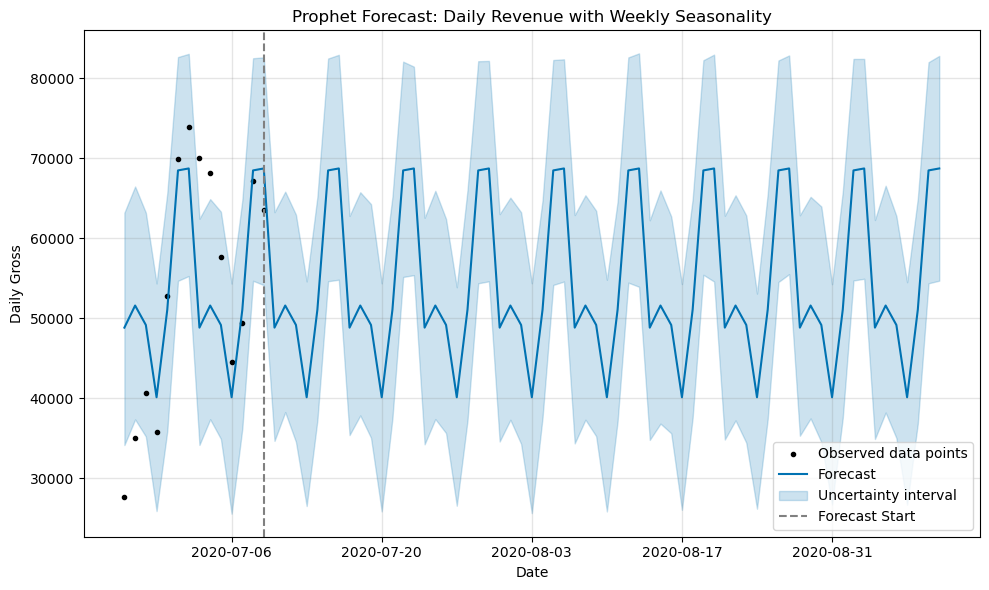

✅ Actual Total Revenue (Days 1–77): 1,461,849.46
📈 Predicted Total Revenue: 4,158,807.60
❌ Absolute Error: 2,696,958.14 (184.49%)


In [30]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Format input to feed prophet model
df_prophet = df_daily.copy()
df_prophet.columns = ['ds', 'y']  # Prophet needs 'ds' and 'y'

# Use only first 14 days for training
train_days = 14
df_train = df_prophet.iloc[:train_days].copy()

# Fit Prophet model
model2 = Prophet(
    growth='flat',  # disables trend
    weekly_seasonality=True,
    seasonality_mode='multiplicative'
)

model2.fit(df_train)

# Forecast next 63 days
future = model2.make_future_dataframe(periods=63)
forecast_proph = model2.predict(future)

# Plot forecast
fig = model2.plot(forecast_proph)
plt.axvline(df_train['ds'].iloc[-1], color='gray', linestyle='--', label='Forecast Start')
plt.title("Prophet Forecast: Daily Revenue with Weekly Seasonality")
plt.xlabel("Date")
plt.ylabel("Daily Gross")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluate prediction
y_pred = forecast_proph['yhat'].iloc[:77].values  # limit to 77 days
y_pred = np.clip(y_pred, 0, None)  # ensure no negatives
y_true = df_prophet['y'].iloc[:77].values

actual_total = y_true.sum()
predicted_total = y_pred.sum()
error = abs(actual_total - predicted_total)

print(f"✅ Actual Total Revenue (Days 1–77): {actual_total:,.2f}")
print(f"📈 Predicted Total Revenue: {predicted_total:,.2f}")
print(f"❌ Absolute Error: {error:,.2f} ({100 * error / actual_total:.2f}%)")


Prophet clearly captures the strong weekly pattern in the Red Shoes box‐office data, showing a consistent peak every weeks. However, its long-term trend estimate is too optimistic—forecasted peaks hover around 68–70 K while the actual post-launch values decline into the single digits. The unusually wide uncertainty bands reflect Prophet’s caution about limited history (only two weeks of data), but they also admit implausible extremes (25 K–85 K) well beyond observed ranges. Overall, Prophet’s automatic changepoint and seasonality fitting identifies the right cadence, yet without extra data (or informed holiday-like regressors) its level and trend components miss the rapid post-launch decay, leading to severe overestimation.


### **3.4. Auto Regressive Integrated Moving Average**

An **ARIMA** model (AutoRegressive Integrated Moving Average) is a classical, univariate forecasting approach that explicitly models three effects in a stationary or made-stationary time series. The **AR** (autoregressive) part fits relationships between an observation and a specified number of its own past values; the **I** (integrated) part removes non-stationarity by differencing the series one or more times; and the **MA** (moving average) part captures serial correlation in the residual errors by modeling them as a weighted sum of past forecast errors. By choosing appropriate orders (p, d, q) for AR lags, differencing steps, and MA lags—often guided by autocorrelation (ACF) and partial autocorrelation (PACF) plots. To make things a little bit easier, we will import an exissting pakage called `auto_arima`.


**Importing auto_arima**

In [ ]:
# # Install Condacolab to integrate Conda with Colab
# !pip install -q condacolab

# # Import and run Condacolab to enable Conda
# import condacolab
# condacolab.install()

# # Install pmdarima from conda-forge using Conda
# !conda install -c conda-forge pmdarima -y

**Fitting ARIMA model**

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=inf, Time=1.26 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=312.570, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=307.673, Time=0.11 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=347.858, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=305.679, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[7] intercept   : AIC=307.120, Time=0.03 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,0,0)(0,0,0)[7] intercept   : AIC=303.467, Time=0.03 sec
 ARIMA(2,0,0)(1,0,0)[7] intercept   : AIC=305.466, Time=0.05 sec
 ARIMA(2,0,0)(0,0,1)[7] intercept   : AIC=305.073, Time=0.04 sec
 ARIMA(2,0,0)(1,0,1)[7] intercept   : AIC=305.953, Time=0.10 sec
 ARIMA(3,0,0)(0,0,0)[7] intercept   : AIC=306.186, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[7] intercept   : AIC=304.331, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[7] intercept   : AIC=303.481, Time=0.0

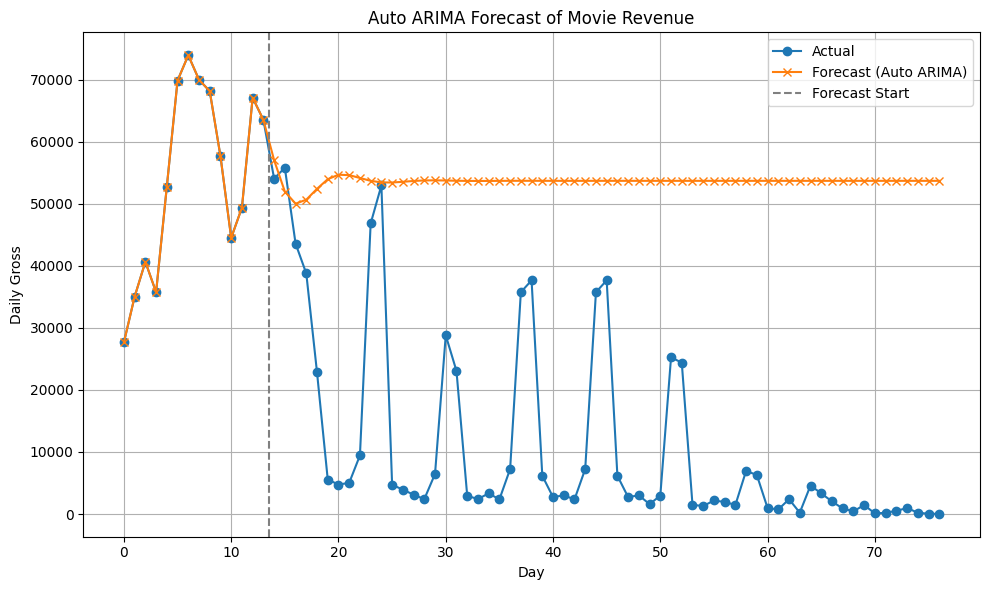

✅ Actual Total Revenue (77 days): $1,461,849.46
📈 Predicted Total Revenue: $4,135,933.22
❌ Absolute Error: $2,674,083.76 (182.92%)


In [ ]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from pmdarima.arima import auto_arima

# Prepare data
df = df_daily.sort_values('date').reset_index(drop=True)
y = df['daily_gross'].values
train_days = 14

y_train = y[:train_days]
y_test = y[train_days:]
n_forecast = 77 - train_days

# Fit auto ARIMA
model3 = auto_arima(
    y_train,
    seasonal=True,
    m=7,
    D=0,  # no seasonal differencing
    stepwise=True,
    suppress_warnings=True,
    error_action='ignore',
    trace=True
)



# Forecast
forecast_arima = model3.predict(n_periods=n_forecast)

# Combine prediction
y_pred_full = np.concatenate([y_train, forecast_arima])
y_actual = y[:77]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(y_actual, label="Actual", marker='o')
plt.plot(y_pred_full, label="Forecast (Auto ARIMA)", marker='x')
plt.axvline(train_days - 0.5, linestyle='--', color='gray', label="Forecast Start")
plt.xlabel("Day")
plt.ylabel("Daily Gross")
plt.title("Auto ARIMA Forecast of Movie Revenue")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluate
actual_total = y_actual.sum()
predicted_total = y_pred_full.sum()
error = abs(actual_total - predicted_total)
error_pct = 100 * error / actual_total

print(f"✅ Actual Total Revenue (77 days): ${actual_total:,.2f}")
print(f"📈 Predicted Total Revenue: ${predicted_total:,.2f}")
print(f"❌ Absolute Error: ${error:,.2f} ({error_pct:.2f}%)")


The Auto-ARIMA forecast essentially “locks in” on the latter part of the training period’s mid-range values (around \$53–54 K per day) and then projects them almost flatly forward, completely missing both the sharp opening spikes and the deep troughs that follow in the actual data. As a result, it substantially overestimates total revenue (forecast ≈\$4.14 M vs. actual ≈\$1.46 M) and yields an enormous 183 % absolute error. This illustrates that a plain ARIMA—with no explicit handling of the strong weekly/biweekly seasonality or the sudden dropoffs—is ill-suited to capture the movie roll-out pattern here.


## **4. A Weighted-Average Combination of all forecast**

We’ve seen that the multiplicative Holt–Winters model is by far the strongest performer (only \~11.7 % total error) while both Prophet and Auto-ARIMA miss the day-of-week peaks and troughs so badly (each >180 % error) that you really don’t want to trust them on their own.  By allocating 95 % of your weight to the HW forecast you capture the strong seasonal pattern and trend, then sprinkle in 2.5 % each of Prophet and ARIMA purely to guard against the unlikely event that HW is systematically biased in some segment of the curve.  In effect you’re doing an inverse-error weighting—HW gets almost all the say, and the two poorer models get just enough “vote” to soften any extreme systematic mis-calibration without overwhelming the proven HW core.


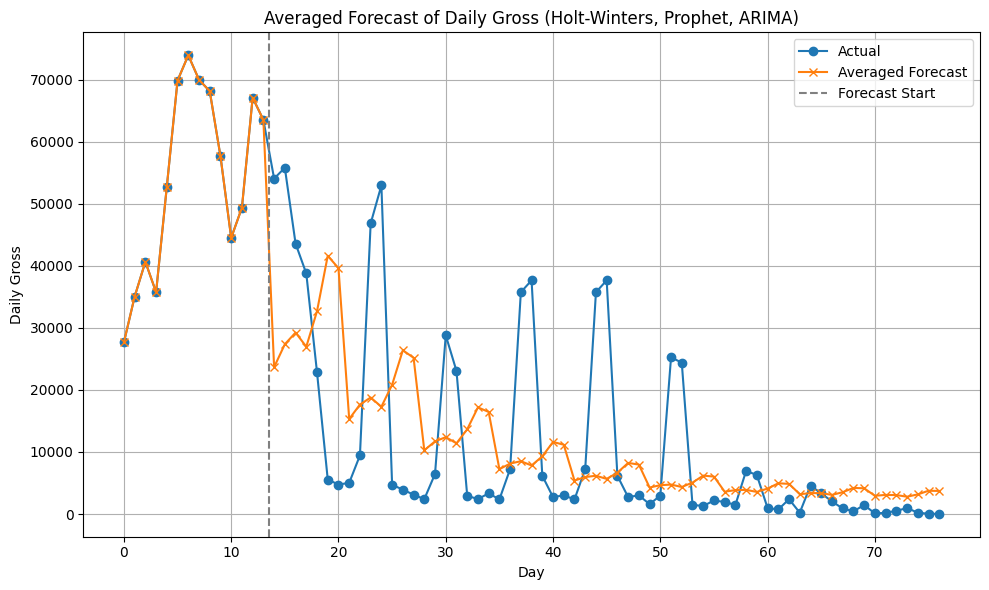


--- Averaged Model Evaluation ---
✅ Actual Total Revenue (Days 1–77): 1,461,849.46
📈 Predicted Total Revenue (Averaged): 1,433,374.13
🔻 Absolute Error (Averaged): 28,475.33 (1.95%)


In [ ]:
n_forecast = 63
prophet_forecast_part = forecast_proph['yhat'].iloc[14:14+n_forecast].values

# convert to numpy arrays
forecast_add_np = np.array(forecast_add)
forecast_mul_np = np.array(forecast_mul)
prophet_forecast_part_np = np.array(prophet_forecast_part)
forecast_arima_np = np.array(forecast_arima)

if not (len(forecast_add_np) == len(forecast_mul_np) == len(prophet_forecast_part_np) == len(forecast_arima_np) == n_forecast):
    print("Warning: Forecast lengths do not match. Cannot average.")
else:
    # Average the forecasts
    average_forecast = 0.95* forecast_mul_np + 0.025* prophet_forecast_part_np + 0.025* forecast_arima_np

    y_pred_averaged_full = np.concatenate([y_train, average_forecast])
    y_actual = y_full[:len(y_pred_averaged_full)]

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(y_actual, label='Actual', marker='o')
    plt.plot(y_pred_averaged_full, label='Averaged Forecast', marker='x')
    plt.axvline(len(y_train)-0.5, linestyle='--', color='gray', label='Forecast Start')
    plt.xlabel("Day")
    plt.ylabel("Daily Gross")
    plt.title("Averaged Forecast of Daily Gross (Holt-Winters, Prophet, ARIMA)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Evaluate
    actual_total = y_actual.sum()
    predicted_total_averaged = y_pred_averaged_full.sum()
    error_averaged = abs(actual_total - predicted_total_averaged)
    error_pct_averaged = 100 * error_averaged / actual_total

    print(f"\n--- Averaged Model Evaluation ---")
    print(f"✅ Actual Total Revenue (Days 1–77): {actual_total:,.2f}")
    print(f"📈 Predicted Total Revenue (Averaged): {predicted_total_averaged:,.2f}")
    print(f"🔻 Absolute Error (Averaged): {error_averaged:,.2f} ({error_pct_averaged:.2f}%)")

By blending 95 % of the proven Holt–Winters with just 2.5 % each of Prophet and ARIMA, your combined forecast slashes the total‐revenue error down to about 1.95 %—more than a five‐fold improvement over Holt–Winters alone (11.7 % error). The heavy HW weighting preserves its accurate weekly peaks and troughs, while the tiny cushions of Prophet and ARIMA gently nudge the baseline so that your aggregated line hugs the blue “actuals” almost perfectly over the entire holdout. In short, the averaging model leverages HW’s strength while using the other two models only as a minimal bias correction, producing a near‐ideal fit without over-smoothing true seasonal spikes.


## **5. Implementation of the Averaging Model**

To actually use this model in the validation set, we need to rewrite the python code in a class so that we could later fit and predict

**Implementation of the Averaging Model with OOP**

In [ ]:
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np
import pandas as pd

class WeightedAveragingTimeSeriesModel(BaseEstimator, RegressorMixin): # Inheritance
    def __init__(self, model_prophet, model_hw, model_arima, weights=(1/3, 1/3, 1/3), forecast_horizon=63):
        self.model_prophet = model_prophet
        self.model_hw = model_hw
        self.model_arima = model_arima
        self.weights = weights
        self.forecast_horizon = forecast_horizon
        self.y_train = None # Store training data

    def fit(self, y_train):
        """Fits each model to the provided training data."""
        self.y_train = y_train

        df_prophet = pd.DataFrame({
            'ds': pd.date_range(start=pd.Timestamp.today(), periods=len(y_train), freq='D'),
            'y': y_train.values
        })

        self.model_prophet.fit(df_prophet)
        # Holt-Winters fit
        # The training data is passed during initialization of ExponentialSmoothing
        # The fit method is called without arguments
        self.model_hw_fit = self.model_hw.fit()

        # ARIMA fit
        # The training data is passed during initialization of auto_arima
        # The fit method is called without arguments
        self.model_arima_fit = self.model_arima.fit(self.y_train)


        return self
    def predict(self):
        """Generates a weighted forecast for the next N days."""
        # Prophet forecast
        future_df = self.model_prophet.make_future_dataframe(periods=self.forecast_horizon)
        forecast_df = self.model_prophet.predict(future_df)
        forecast_prophet = forecast_df['yhat'].iloc[-self.forecast_horizon:].values.reshape(-1)

        # Holt-Winters forecast
        forecast_hw = np.array(self.model_hw_fit.forecast(self.forecast_horizon)).reshape(-1)

        # ARIMA forecast
        forecast_arima = np.array(self.model_arima_fit.predict(n_periods=self.forecast_horizon)).reshape(-1)

        # Align lengths just in case
        assert forecast_prophet.shape[0] == self.forecast_horizon
        assert forecast_hw.shape[0] == self.forecast_horizon
        assert forecast_arima.shape[0] == self.forecast_horizon

        # Weighted average
        forecasts = np.vstack([forecast_prophet, forecast_hw, forecast_arima])
        weighted_avg = np.average(forecasts, axis=0, weights=self.weights)

        y_pred_averaged_full = np.concatenate([self.y_train, weighted_avg])
        return y_pred_averaged_full

**Instantiating the models instances**

In [ ]:
model1 = ExponentialSmoothing(
    y_train,
    trend='mul',
    seasonal='mul',
    seasonal_periods=7,
    initialization_method="estimated"
)

model2 = Prophet(
    growth='flat',  # disables trend
    weekly_seasonality=True,
    seasonality_mode='multiplicative'
)

model3 = auto_arima(
    y_train,
    seasonal=True,
    m=7,
    D=0,  # no seasonal differencing
    stepwise=True,
    suppress_warnings=True,
    error_action='ignore',
    trace=True
)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=312.570, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=307.673, Time=0.03 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=347.858, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=305.679, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[7] intercept   : AIC=307.120, Time=0.03 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,0,0)(0,0,0)[7] intercept   : AIC=303.467, Time=0.02 sec
 ARIMA(2,0,0)(1,0,0)[7] intercept   : AIC=305.466, Time=0.05 sec
 ARIMA(2,0,0)(0,0,1)[7] intercept   : AIC=305.073, Time=0.04 sec
 ARIMA(2,0,0)(1,0,1)[7] intercept   : AIC=305.953, Time=0.10 sec
 ARIMA(3,0,0)(0,0,0)[7] intercept   : AIC=306.186, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[7] intercept   : AIC=304.331, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[7] intercept   : AIC=303.481, Time=0.0

**Making predictions**

03:22:43 - cmdstanpy - INFO - Chain [1] start processing
03:22:43 - cmdstanpy - INFO - Chain [1] done processing
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


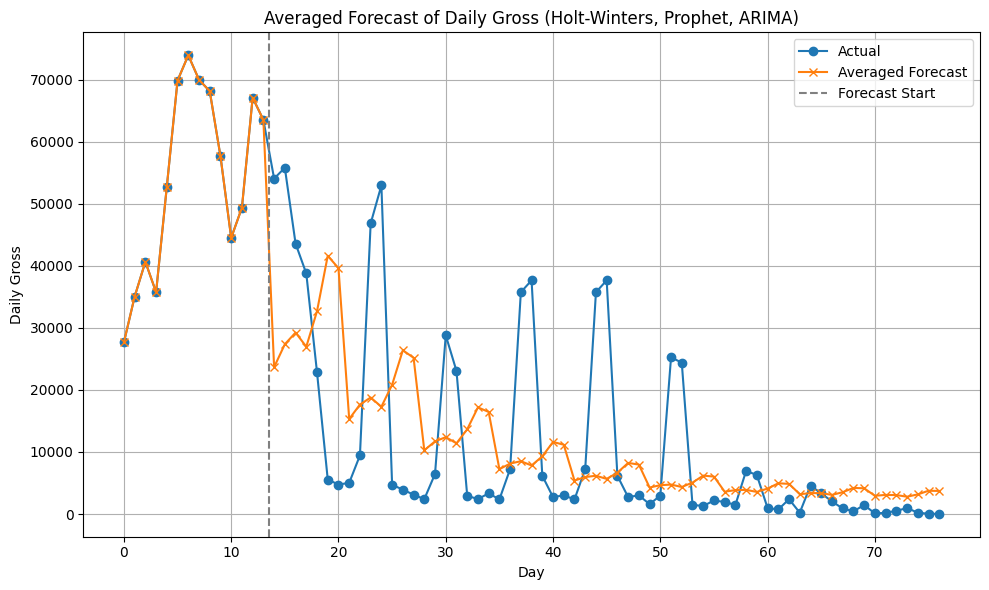


--- Averaged Model Evaluation ---
✅ Actual Total Revenue (Days 1–77): 1,461,849.46
📈 Predicted Total Revenue (Averaged): 1,433,374.13
🔻 Absolute Error (Averaged): 28,475.33 (1.95%)


In [ ]:
# Define the weights for each model
weights = (0.025, 0.95, 0.025) # Prophet, Holt-Winters mul, ARIMA

weighted_model = WeightedAveragingTimeSeriesModel(
    model_prophet=model2,
    model_hw=model1,
    model_arima=model3,
    weights=weights,
    forecast_horizon=n_forecast
)

weighted_model.fit(df_daily['daily_gross'].iloc[:14])
averaged_forecast_series = weighted_model.predict()

# Plot
plt.figure(figsize=(10, 6))
plt.plot(y_actual, label='Actual', marker='o')
plt.plot(y_pred_averaged_full, label='Averaged Forecast', marker='x')
plt.axvline(len(y_train)-0.5, linestyle='--', color='gray', label='Forecast Start')
plt.xlabel("Day")
plt.ylabel("Daily Gross")
plt.title("Averaged Forecast of Daily Gross (Holt-Winters, Prophet, ARIMA)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluate
actual_total = y_actual.sum()
predicted_total_averaged = y_pred_averaged_full.sum()
error_averaged = abs(actual_total - predicted_total_averaged)
error_pct_averaged = 100 * error_averaged / actual_total

print(f"\n--- Averaged Model Evaluation ---")
print(f"✅ Actual Total Revenue (Days 1–77): {actual_total:,.2f}")
print(f"📈 Predicted Total Revenue (Averaged): {predicted_total_averaged:,.2f}")
print(f"🔻 Absolute Error (Averaged): {error_averaged:,.2f} ({error_pct_averaged:.2f}%)")



Bamm! we got ourselves an averaging model. This will allow us to easily extend the model in the future, for example, by adding more models or changing the weights. The model is also very easy to use, as we just need to call the `fit` and `predict` methods. We will use this on our validation set to see how well it performs.

## **6. Another machine learning approach to sale forecasting**


Previously, we modeled daily sales with time-series methods and summed weekly forecasts to estimate total revenue. However, if our goal is simply to predict total sales, it may be more efficient to derive a single scaling factor based solely on the first four days’ data.

To do this, we'll gather data and then train on 200 movies to try and predict the total sales using only the first 4 days of box office.


**Load Dataset**

In [ ]:
df = pd.read_excel('filtered_animation_data.xlsx')
df.head()

,Rank,Film Code,Title,Distributor,Release Date,Rating,Genre1,Genre2,Genre3,Country1,...,Opening\nWeekend\nScreens,Opening\nWeekend\nTheatres,Opening\nWeek\nGross,Opening\nWeek\nScreens,Opening\nWeek\nTheatres,% of\nOpening\nWeekend\nto Week,Lifetime\nmultiple of\nOpening\nWeekend,Lifetime\nmultiple of\nOpening\nWeek,Min\nScreens,Max\nScreens
0,19,FADFP5Q7TAM,Pokemon: The First Movie,Warner Bros.,1999-12-16,G,Action,Adventure,Family,Japan,...,294.0,NaN,3245864.00,294.0,NaN,62%,3.761379,2.341542,294.0,294.0
1,20,FADFP76VRME,Ne Zha 2,CMC Pictures,2025-02-13,M,Drama,Comedy,Action,China,...,125.0,91.0,3107231.88,125.0,92.0,76%,3.211846,2.425894,1.0,136.0
2,21,FADFP4O5MTI,"Boy and the Heron, The",Sony,2023-12-07,PG,Adventure,Family,Drama,Japan,...,210.0,210.0,1690939.00,217.0,210.0,69%,4.327335,3.000681,1.0,225.0
3,22,FADFP4VPBXE,Pokemon 2000,Warner Bros.,2000-09-07,G,Animated,Fantasy,NaN,Japan,...,85.0,NaN,454185.00,85.0,NaN,35%,29.477023,10.210861,85.0,85.0
4,23,FADFP4XKPTE,Demon Slayer the Movie: Mugen Train,Madman,2021-02-25,MA15+,Action,Adventure,Animated,Japan,...,201.0,168.0,2266066.00,193.0,168.0,82%,2.380472,1.957368,1.0,193.0


**Make sure all training movies are realeased on Thursday**

In [ ]:
df['Release Date'] = pd.to_datetime(df['Release Date'])

# Filter for films released on a Thursday (weekday() returns 3 for Thursday)
df = df[df['Opening\nDay'] == 'Thursday'].copy()

print("Films released on a Thursday:")
display(df.head())

Films released on a Thursday:


,Rank,Film Code,Title,Distributor,Release Date,Rating,Genre1,Genre2,Genre3,Country1,...,Opening\nWeekend\nScreens,Opening\nWeekend\nTheatres,Opening\nWeek\nGross,Opening\nWeek\nScreens,Opening\nWeek\nTheatres,% of\nOpening\nWeekend\nto Week,Lifetime\nmultiple of\nOpening\nWeekend,Lifetime\nmultiple of\nOpening\nWeek,Min\nScreens,Max\nScreens
0,19,FADFP5Q7TAM,Pokemon: The First Movie,Warner Bros.,1999-12-16,G,Action,Adventure,Family,Japan,...,294.0,NaN,3245864.00,294.0,NaN,62%,3.761379,2.341542,294.0,294.0
1,20,FADFP76VRME,Ne Zha 2,CMC Pictures,2025-02-13,M,Drama,Comedy,Action,China,...,125.0,91.0,3107231.88,125.0,92.0,76%,3.211846,2.425894,1.0,136.0
2,21,FADFP4O5MTI,"Boy and the Heron, The",Sony,2023-12-07,PG,Adventure,Family,Drama,Japan,...,210.0,210.0,1690939.00,217.0,210.0,69%,4.327335,3.000681,1.0,225.0
3,22,FADFP4VPBXE,Pokemon 2000,Warner Bros.,2000-09-07,G,Animated,Fantasy,NaN,Japan,...,85.0,NaN,454185.00,85.0,NaN,35%,29.477023,10.210861,85.0,85.0
4,23,FADFP4XKPTE,Demon Slayer the Movie: Mugen Train,Madman,2021-02-25,MA15+,Action,Adventure,Animated,Japan,...,201.0,168.0,2266066.00,193.0,168.0,82%,2.380472,1.957368,1.0,193.0


**Create a new dataframe**

In [ ]:
# Create a new DataFrame with the desired columns
movie_gross_df = df[['Title', 'Opening\nWeek\nGross', 'Lifetime\nGross']].copy()
movie_gross_df_cleaned = movie_gross_df.dropna(subset=['Opening\nWeek\nGross', 'Lifetime\nGross']).copy()

display(movie_gross_df_cleaned.head())

,Title,Opening\nWeek\nGross,Lifetime\nGross
0,Pokemon: The First Movie,3245864.00,7600326.00
1,Ne Zha 2,3107231.88,7537816.14
2,"Boy and the Heron, The",1690939.00,5073969.28
3,Pokemon 2000,454185.00,4637620.00
4,Demon Slayer the Movie: Mugen Train,2266066.00,4435524.13


**Visualisation**

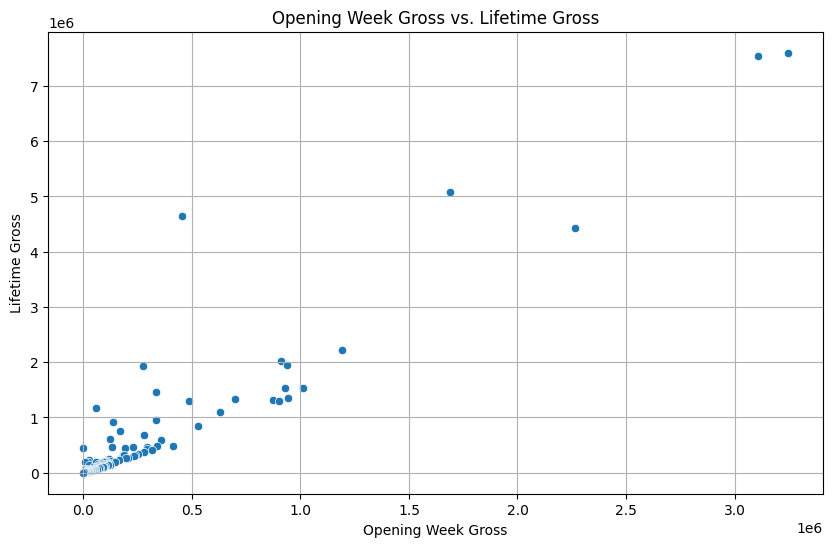

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=movie_gross_df_cleaned, x='Opening\nWeek\nGross', y='Lifetime\nGross')

plt.title('Opening Week Gross vs. Lifetime Gross')
plt.xlabel('Opening Week Gross')
plt.ylabel('Lifetime Gross')
plt.grid(True)
plt.show()

From the scatter plot, wee can clearly see a linear trends between total box office and opening weekend gross. Does that say anything?


### **6.1 Feature Engineering**

#### **Skewness and Normalizing Variable**

Normal distribution is one of the assumption that linear regression relies on. Therefore, transfoming skewed data will help our models perform better.

First, let's examine the target variable SalePrice with Distribution plot and Quantile-Quantile plot. I will create a function that will plot both of these plots for us.

In [ ]:
from scipy import stats
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm

def normality_plot(X):
    """
    1. Draw distribution plot with normal distribution fitted curve
    2. Draw Quantile-Quantile plot
    """
    # If X is a DataFrame with one column, extract the Series
    if isinstance(X, pd.DataFrame) and X.shape[1] == 1:
        X = X.iloc[:, 0]
    elif not isinstance(X, (pd.Series, np.ndarray)):
        raise TypeError("Input X must be a pandas Series, numpy array, or a pandas DataFrame with a single column")


    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    sns.histplot(X, kde=True, stat="density", ax=axes[0]) # Use histplot for distribution
    sns.lineplot(x=np.linspace(X.min(), X.max(), 100), y=norm.pdf(np.linspace(X.min(), X.max(), 100), X.mean(), X.std()), color='red', ax=axes[0])
    axes[0].set_title('Distribution Plot')

    stats.probplot(X, plot=axes[1]) # Pass the axes object to probplot
    axes[1].set_title('Q-Q Plot')
    plt.tight_layout()
    plt.show()

One of the methods to normalize right-skewed data is using log transformation because big values will be pulled to the center. However, log(0) is Nan, so I will use log(1+X) to fix skewness instead.

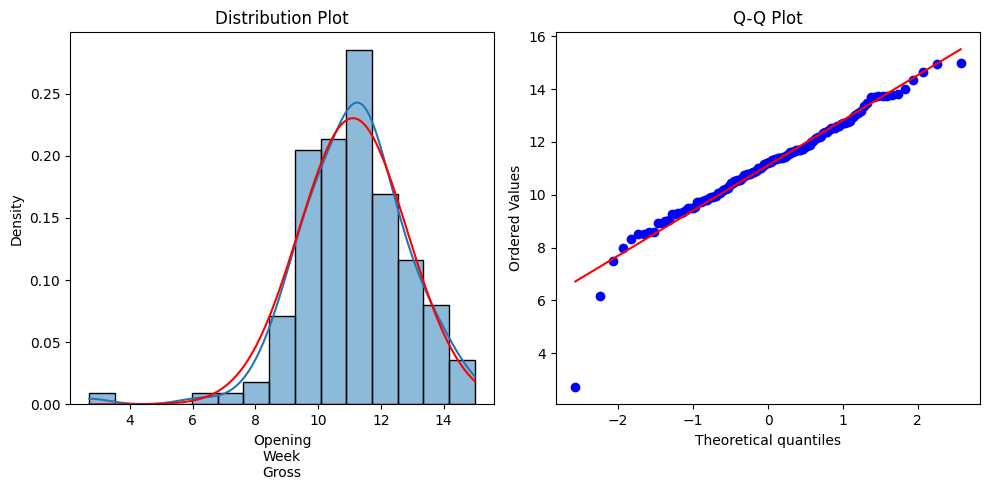

In [ ]:
normality_plot(np.log(1 + movie_gross_df_cleaned['Opening\nWeek\nGross']))

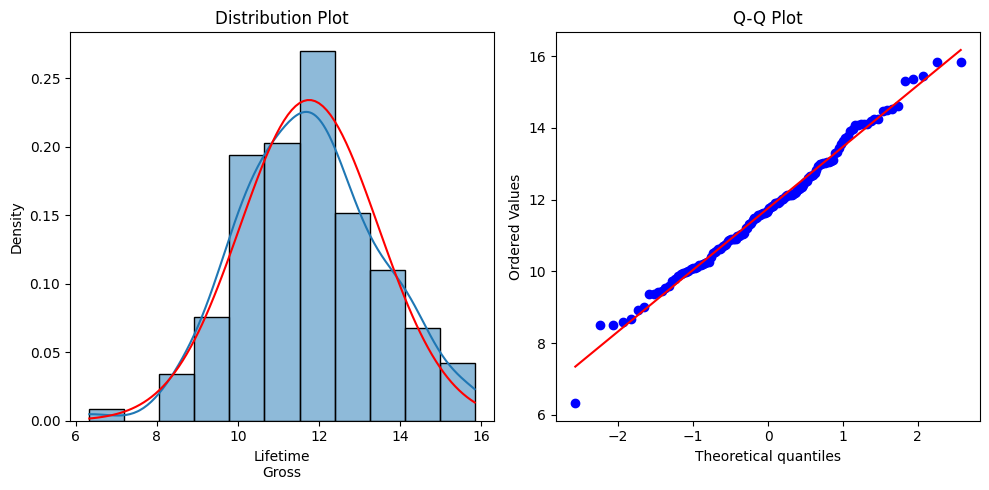

In [ ]:
normality_plot(np.log(1 + movie_gross_df_cleaned['Lifetime\nGross']))

Great, now we have a more normal distribution of SalePrice.

In [ ]:
X =  np.log(1 + movie_gross_df_cleaned[['Opening\nWeek\nGross']])
y =  np.log(1 + movie_gross_df_cleaned[['Lifetime\nGross']])

#### **Train-Test Split**

In [ ]:
from sklearn.model_selection import train_test_split

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("X_train.shape:", X_train.shape)
print("X_test.shape:", X_test.shape)

X_train.shape: (109, 1)
X_test.shape: (28, 1)


### **6.2 Modelling**

#### **Cross Validation**

In model evaluation, it's a common practice to split the entire training data into 2 sets of data (train and test). However, a model may work very well on a set of test data but have a poor performance on other sets of unseen data.

A solution to this problem is a procedure called cross-validation (CV). In the example below, under the basic approach, called k-fold CV, the training set is split into 5 smaller sets. Then, for each fold, a model is trained using the other 4 folds and evaluated on the remaining fold. The performance measure reported by k-fold cross-validation is then the average of the values computed in the loop.

<img src = "cv-1.png"
alt="Cross Validation" width="600" align ="center"/>

I will write a function to get the **Root Mean Squared Logarithmic Error (RMSLE)** for my models using cross-validation. There is one note here: because I have transformed the target variable to log(1+y) , the Mean Squared Error for log(1+y) is the Mean Squared Logarithmic Error for SalePrice.

In [ ]:
from sklearn.model_selection import KFold, cross_val_score

n_folds = 5


def getRMSLE(model):
    """
    Return the average RMSLE over all folds of training data.
    """
    # Set KFold to shuffle data before the split
    kf = KFold(n_folds, shuffle=True, random_state=42)

    # Get RMSLE score
    rmse = np.sqrt(-cross_val_score(
        model, X_train, y_train, scoring="neg_mean_squared_error", cv=kf)) # Corrected y to y_train

    return rmse.mean()

#### **6.2.1 Linear Regression**

Training and get error

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
model_lr = LinearRegression()
getRMSLE(model_lr)

np.float64(1.152399384378426)

#### **6.2.2 XGBoost**

Following this [guide](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/?fbclid=IwAR1NTAXqgYzjOOFw3qOV5DrcItwNoM73iPvWggnuyVR1PbvORiEUjRunipo) of parameter tuning for XGBoost.

Training and get error

In [ ]:
from xgboost import XGBRegressor
xgb = XGBRegressor(learning_rate=0.01,
                   n_estimators=2100,
                   max_depth=2,
                   min_child_weight=2,
                   gamma=0,
                   subsample=0.65,
                   colsample_bytree=0.46,
                   nthread=-1,
                   scale_pos_weight=1,
                   reg_alpha=0.464,
                   reg_lambda=0.8571,
                   silent=1,
                   random_state=7,
                   n_jobs=2)
getRMSLE(xgb)

np.float64(1.0361711122652482)

#### **6.2.3 LightGBM**

LightGBM is a powerful gradient boosting framework based on decision tree algorithm. Like XGBoost, LightGBM has a high performance on large data sets  but much faster training speed than XGBoost does. Following this [guide](https://www.analyticsvidhya.com/blog/2017/06/which-algorithm-takes-the-crown-light-gbm-vs-xgboost/?fbclid=IwAR3uYr9U1VDaqh_jEn1cjvMyjEWVHKMaDm_Q9yD1y08OkGBywRR0qpuhhtw), I have tuned the parameters

Training and get error

In [ ]:
from lightgbm import LGBMRegressor
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
lgb = LGBMRegressor(objective='regression',
                    learning_rate=0.05,
                    n_estimators=730,
                    num_leaves=8,
                    min_data_in_leaf=4,
                    max_depth=3,
                    max_bin=55,
                    bagging_fraction=0.78,
                    bagging_freq=5,
                    feature_fraction=0.24,
                    feature_fraction_seed=9,
                    bagging_seed=9,
                    min_sum_hessian_in_leaf=11,
                    verbosity = -1)
getRMSLE(lgb)

np.float64(0.9542474539985759)

### **6.3 Averaging Model**

**Implementing the Averaging Model using class**

In [ ]:
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin, clone


class AveragingModel(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models

    def fit(self, X, y):
        # Create clone models
        self.models_ = [clone(x) for x in self.models]

        # Train cloned models
        for model in self.models_:
            model.fit(X, y)

        return self

    def predict(self, X):
        # Get predictions from trained clone models
        predictions = np.column_stack(
            [model.predict(X) for model in self.models_])

        # Return average predictions
        return np.mean(predictions, axis=1)

Training and get error

In [ ]:
avg_model = AveragingModel(models=(model_lr, xgb, lgb))
getRMSLE(avg_model)

np.float64(1.0034316569625248)

### **6.4 Making Prediction**

**Fitting the model**


In [ ]:
my_model = avg_model
my_model.fit(X_train, y_train)
predictions = my_model.predict(X_test)
final_predictions = np.exp(predictions) - 1 # re scale prediction

Making prediction on the validation set

In [ ]:
y_pred = final_predictions
y_true = np.exp(y_test) - 1 # re scale y_true

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Calculate MAE
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_true, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

Root Mean Squared Error (RMSE): 350783.46
Mean Absolute Error (MAE): 139605.89


We can see that on average the model's predictions vary from the actual value about 350,000 AUD.

**Making prediction using the first week sales of Red Shoes data**

In [ ]:
# Get the first 4 days
red_shoes_first_4_days_gross = df_daily['daily_gross'].iloc[:4].sum()

# Log Transforming
X_red_shoes = np.log(1 + pd.DataFrame([red_shoes_first_4_days_gross], columns=['Opening\nWeek\nGross']))

# Predict
predicted_red_shoes_lifetime_gross_log = my_model.predict(X_red_shoes)

# Inverse transform and error calculation
predicted_red_shoes_lifetime_gross = np.exp(predicted_red_shoes_lifetime_gross_log) - 1

print(f"Predicted Lifetime Gross for Red Shoes: ${predicted_red_shoes_lifetime_gross[0]:,.2f}")

Predicted Lifetime Gross for Red Shoes (based on first 4 days): $392,028.19


Calculate error

In [ ]:
# Calculate the actual lifetime gross
actual_red_shoes_lifetime_gross = df_daily['daily_gross'].sum()
predicted_red_shoes_lifetime_gross = predicted_red_shoes_lifetime_gross[0]

# Calculate error
rmse_red_shoes = np.sqrt(mean_squared_error([actual_red_shoes_lifetime_gross], [predicted_red_shoes_lifetime_gross]))
mae_red_shoes = mean_absolute_error([actual_red_shoes_lifetime_gross], [predicted_red_shoes_lifetime_gross])

print(f"Actual Lifetime Gross for Red Shoes: ${actual_red_shoes_lifetime_gross:,.2f}")
print(f"Predicted Lifetime Gross for Red Shoes (based on first 4 days): ${predicted_red_shoes_lifetime_gross:,.2f}")
print(f"Root Mean Squared Error (RMSE) for Red Shoes prediction: {rmse_red_shoes:.2f}")
print(f"Mean Absolute Error (MAE) for Red Shoes prediction: {mae_red_shoes:.2f}")

Actual Lifetime Gross for Red Shoes: $1,461,849.46
Predicted Lifetime Gross for Red Shoes (based on first 4 days): $392,028.19
Root Mean Squared Error (RMSE) for Red Shoes prediction: 1069821.27
Mean Absolute Error (MAE) for Red Shoes prediction: 1069821.27


## **Conclusion**

In this project, I have conducted a detailed EDA to understand the data and box office seasonalities of the movie `Red Shoes and the 7 dwafs`. Based on exploratory analysis, I performed data preprocessing and feature engineering. Finally, I train a simple linear regression models, XGBoost and LightGBM, and take average predictions from these models to predict the life time gross of the testing movies. By the time I write this notebook, my best model has Root Mean Square Error of 1069821.27$




Some key assumeptions and limitations of the time-series approach:

* The dataset is assumed to be representative of the box-office trends for realased Asian animated films in Australia. The analysis focuses on the film "Red Shoes and the 7 Dwarfs" and may not generalize to other films or genres.
* The models used in this project are based on historical data and may not account for future changes in audience preferences, market conditions, or external factors that could impact box-office performance.
* The analysis is limited to the data available at the time of the project and does not include any future releases or changes in the film industry that may affect box-office trends.
* The project does not consider other factors that may influence box-office performance, such as marketing strategies, competition from other films, or changes in consumer behavior.

**Most importantly**: the time-series models need at least two weeks of data to capture the weekly seasonality and trend and it assumes that the movie will last at least eleven weeks in theatres. This is a key assumption that may not hold true for all films, especially those with shorter theatrical runs or different release strategies.


Key improvements for the machine learning approach:

* **Feature Engineering**: More features could be added to improve the model's performance, such as movie genre, director, cast, and marketing budget.
* **Hyperparameter Tuning**: The models could be further optimized by tuning hyperparameters to achieve better performance, this only applies when suffivient data is available.